# LERM Applied to ice cores

This notebook recreates Figure 5 from the original publication, applying LERM to ice cores over the Holocene.

In [1]:
import pickle
import random

import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt
from tqdm import tqdm

from pylipd.lipd import LiPD

In [ ]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

Analysis here is largely identical to that for Figures 2 and 3, though we use slightly different parameters.

In [2]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

In [3]:
color_list = sns.color_palette('colorblind')

Here we load the data using [pyLiPD](https://github.com/LinkedEarth/pylipd).

In [4]:
lipd_path = '../data/8k_ice'

all_files = LiPD()

if __name__=='__main__':
    all_files.load_from_dir(lipd_path,parallel=True)

record_names = all_files.get_all_dataset_names()

Loading 8 LiPD files


100%|██████████| 8/8 [00:00<00:00, 17.91it/s]

Loaded..


In [5]:
series_list = []

# We specify the indices of interest in each dataframe by hand here

index_dict = {
    'GRIP.GRIP.1992' : 'd18O',
    'Renland.Johnsen.1992' : 'd18O',
    'EDML.Stenni.2010' : 'bagd18O',
    'EPICADomeC.Stenni.2010' : 'bagd18O',
    'Vostok.Vimeux.2002' : 'temperature',
    'GISP2.Grootes.1997' : 'd18O',
    'NGRIP.NGRIP.2004' : 'd18O',
    'TALDICE.Mezgec.2017' : 'd18O',
}

for record in record_names:
    d = LiPD()
    d.load(f'{lipd_path}/{record}.lpd')
    df = d.get_timeseries_essentials()
    row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
    lat = row['geo_meanLat'].to_numpy()[0]
    lon = row['geo_meanLon'].to_numpy()[0]
    elevation = row['geo_meanElev'].to_numpy()[0]
    value = row['paleoData_values'].to_numpy()[0]
    value_name = row['paleoData_variableName'].to_numpy()[0]
    value_unit = row['paleoData_units'].to_numpy()[0]
    time = row['time_values'].to_numpy()[0]
    time_unit = row['time_units'].to_numpy()[0]
    time_name = row['time_variableName'].to_numpy()[0]
    label = row['dataSetName'].to_numpy()[0]
    geo_series = pyleo.GeoSeries(time=time,
                                 value=value,
                                 lat=lat,
                                 lon=lon,
                                 elevation=elevation,
                                 time_unit=time_unit,
                                 time_name=time_name,
                                 value_name=value_name,
                                 value_unit=value_unit,
                                 label=label,
                                 archiveType='ice')
    series_list.append(geo_series)

geo_ms = pyleo.MultipleGeoSeries(series_list)

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 70.26it/s]
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


Loaded..
NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 78.04it/s]
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/364450205.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


Loaded..
NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 66.34it/s]

Loaded..



/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/364450205.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 103.26it/s]


Loaded..


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 71.73it/s]


Loaded..


/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/364450205.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 46.97it/s]


Loaded..


/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/364450205.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 68.80it/s]


Loaded..


/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/364450205.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 77.09it/s]


Loaded..
NaNs have been detected and dropped.
Time axis values sorted in ascending order


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/geoseries.py:165: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time, value, time_unit, time_name, value_name,
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:267: UserWarning: archiveType should be one of the following: ice-other, ice/rock, coral, documents, glacierice, hybrid, lakesediment, marinesediment, sclerosponge, speleothem, wood, molluskshells, peat, midden, instrumental, model, 
  warnings.warn('archiveType should be one of the following: ' + mystring)


In [6]:
greenland_ms_list = []
antarctica_ms_list = []

for series in geo_ms.series_list:
    if series.lat > 0 or series.label == 'EPICADomeC.Stenni.2010':
        series.time_unit = 'Years BP'
        greenland_ms_list.append(series)
    else:
        series.time_unit = 'Years BP'
        antarctica_ms_list.append(series)

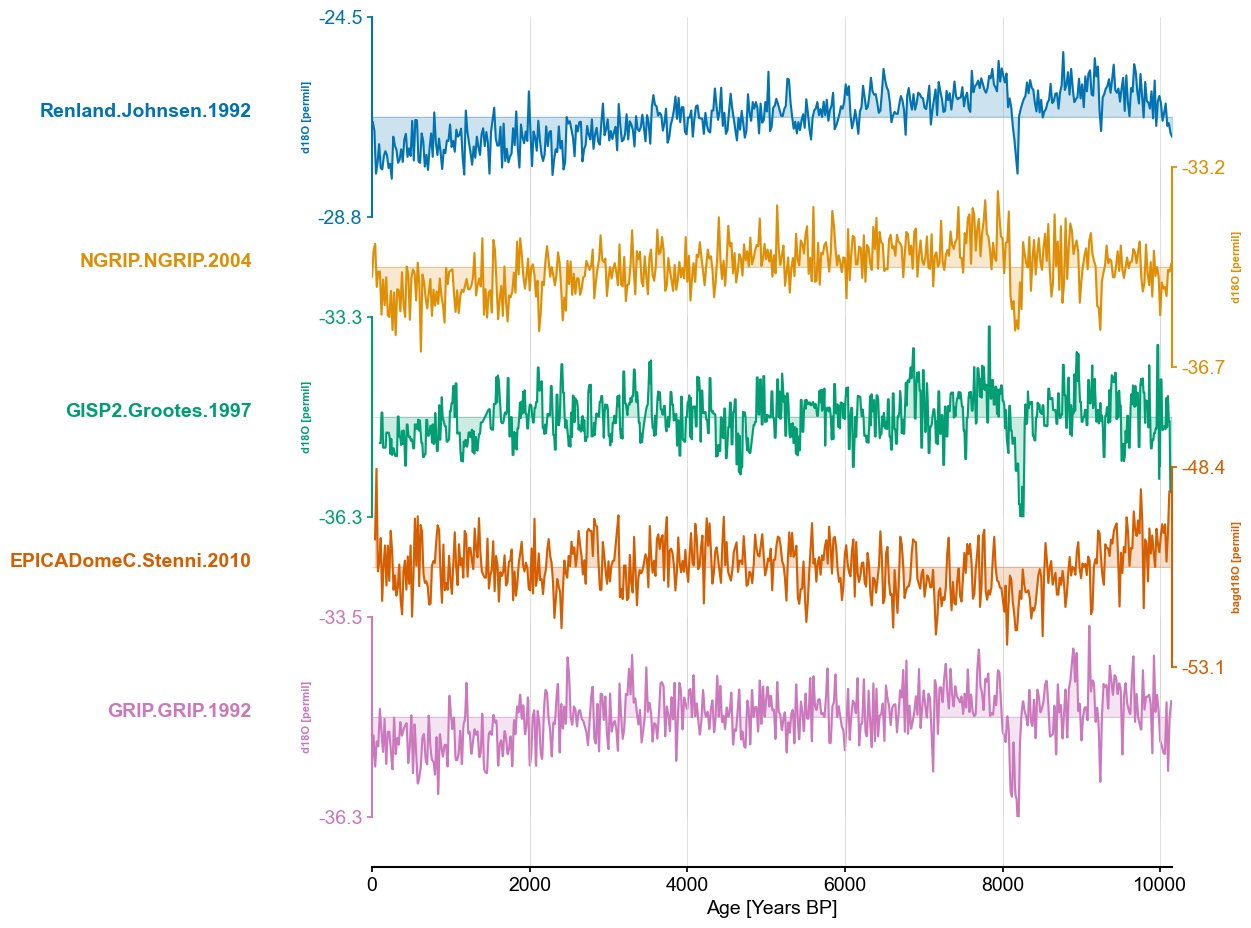

In [7]:
end_time=10150

greenland_ms = pyleo.MultipleSeries([series.slice((0,end_time)).interp() for series in greenland_ms_list])
greenland_ms.stackplot(colors=color_list[:len(greenland_ms.series_list)],figsize=(8,10))

ms_dict = {series.label:series for series in greenland_ms.series_list}

In [8]:
lp_series_dict = {}
m = 12
tau = 4

for idx,series in enumerate(greenland_ms.series_list):
    if series.label != 'EPICADomeC.Stenni.2010':
        amt_series = amt.Series(
            time=series.time,
            value=series.value,
            time_name = series.time_name,
            value_name = series.value_name,
            time_unit = series.time_unit,
            value_unit = series.value_unit,
            label = series.label,
            clean_ts=False,
            sort_ts=None
        ).convert_time_unit('Years').detrend(method='savitzky-golay')
    else:
        amt_series = amt.Series(
            time=series.time,
            value=series.value,
            time_name = series.time_name,
            value_name = series.value_name,
            time_unit = series.time_unit,
            value_unit = series.value_unit,
            label = series.label,
            clean_ts=False,
            sort_ts=None
        ).convert_time_unit('Years')
    td = amt_series.embed(m,tau)
    print(f'{series.label} Tau is: {td.tau}')
    eps = td.find_epsilon(eps=1,target_density=.05,tolerance=.01)
    rm = eps['Output']
    lp = rm.laplacian_eigenmaps(w_size=20,w_incre=4).convert_time_unit('Years BP')
    lp_series_dict[series.label] = lp

/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/3962517463.py:7: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:985: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")


Renland.Johnsen.1992 Tau is: 4
Initial density is 0.0424
Initial density is within the tolerance window!


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/3962517463.py:7: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:985: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating..."

NGRIP.NGRIP.2004 Tau is: 4
Initial density is 0.0217
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0217
Epsilon: 1.1416, Density: 0.0583
Epsilon: 1.1416, Density: 0.0583.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/3962517463.py:7: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:985: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating..."

GISP2.Grootes.1997 Tau is: 4
Initial density is 0.0268
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0268
Epsilon: 1.1158, Density: 0.0605
Epsilon: 1.1158, Density: 0.0605
Epsilon: 1.0631, Density: 0.0426
Epsilon: 1.0631, Density: 0.0426.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/3962517463.py:19: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(


EPICADomeC.Stenni.2010 Tau is: 4
Initial density is 0.0022
Initial density is not within the tolerance window, searching...
Epsilon: 1.4777, Density: 0.0132
Epsilon: 1.8461, Density: 0.0653
Epsilon: 1.6928, Density: 0.0351
Epsilon: 1.8418, Density: 0.0641
Epsilon: 1.7009, Density: 0.0364
Epsilon: 1.8372, Density: 0.0631
Epsilon: 1.7065, Density: 0.0372
Epsilon: 1.8346, Density: 0.0625
Epsilon: 1.7095, Density: 0.0377
Epsilon: 1.8322, Density: 0.0619
Epsilon: 1.7137, Density: 0.0384
Epsilon: 1.8298, Density: 0.0613
Epsilon: 1.7171, Density: 0.0389
Epsilon: 1.8285, Density: 0.0610
Epsilon: 1.7188, Density: 0.0391
Epsilon: 1.8277, Density: 0.0609
Epsilon: 1.7190, Density: 0.0392
Epsilon: 1.8272, Density: 0.0608
Epsilon: 1.8272, Density: 0.0608
Epsilon: 1.7733, Density: 0.0491
Epsilon: 1.7733, Density: 0.0491.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_1021/3962517463.py:7: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:985: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating..."

GRIP.GRIP.1992 Tau is: 4
Initial density is 0.1646
Initial density is not within the tolerance window, searching...
Epsilon: 0.0000, Density: 0.0000
Epsilon: 0.5000, Density: 0.0026
Epsilon: 0.5000, Density: 0.0026
Epsilon: 0.7371, Density: 0.0250
Epsilon: 0.7371, Density: 0.0250
Epsilon: 0.8622, Density: 0.0701
Epsilon: 0.8622, Density: 0.0701
Epsilon: 0.7617, Density: 0.0313
Epsilon: 0.7617, Density: 0.0313
Epsilon: 0.8554, Density: 0.0667
Epsilon: 0.8554, Density: 0.0667
Epsilon: 0.7719, Density: 0.0342
Epsilon: 0.7719, Density: 0.0342
Epsilon: 0.8511, Density: 0.0646
Epsilon: 0.8511, Density: 0.0646
Epsilon: 0.7781, Density: 0.0360
Epsilon: 0.7781, Density: 0.0360
Epsilon: 0.8479, Density: 0.0631
Epsilon: 0.8479, Density: 0.0631
Epsilon: 0.7824, Density: 0.0374
Epsilon: 0.7824, Density: 0.0374
Epsilon: 0.8454, Density: 0.0619
Epsilon: 0.8454, Density: 0.0619
Epsilon: 0.7860, Density: 0.0385
Epsilon: 0.7860, Density: 0.0385
Epsilon: 0.8432, Density: 0.0609
Epsilon: 0.8432, Density: 

/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)


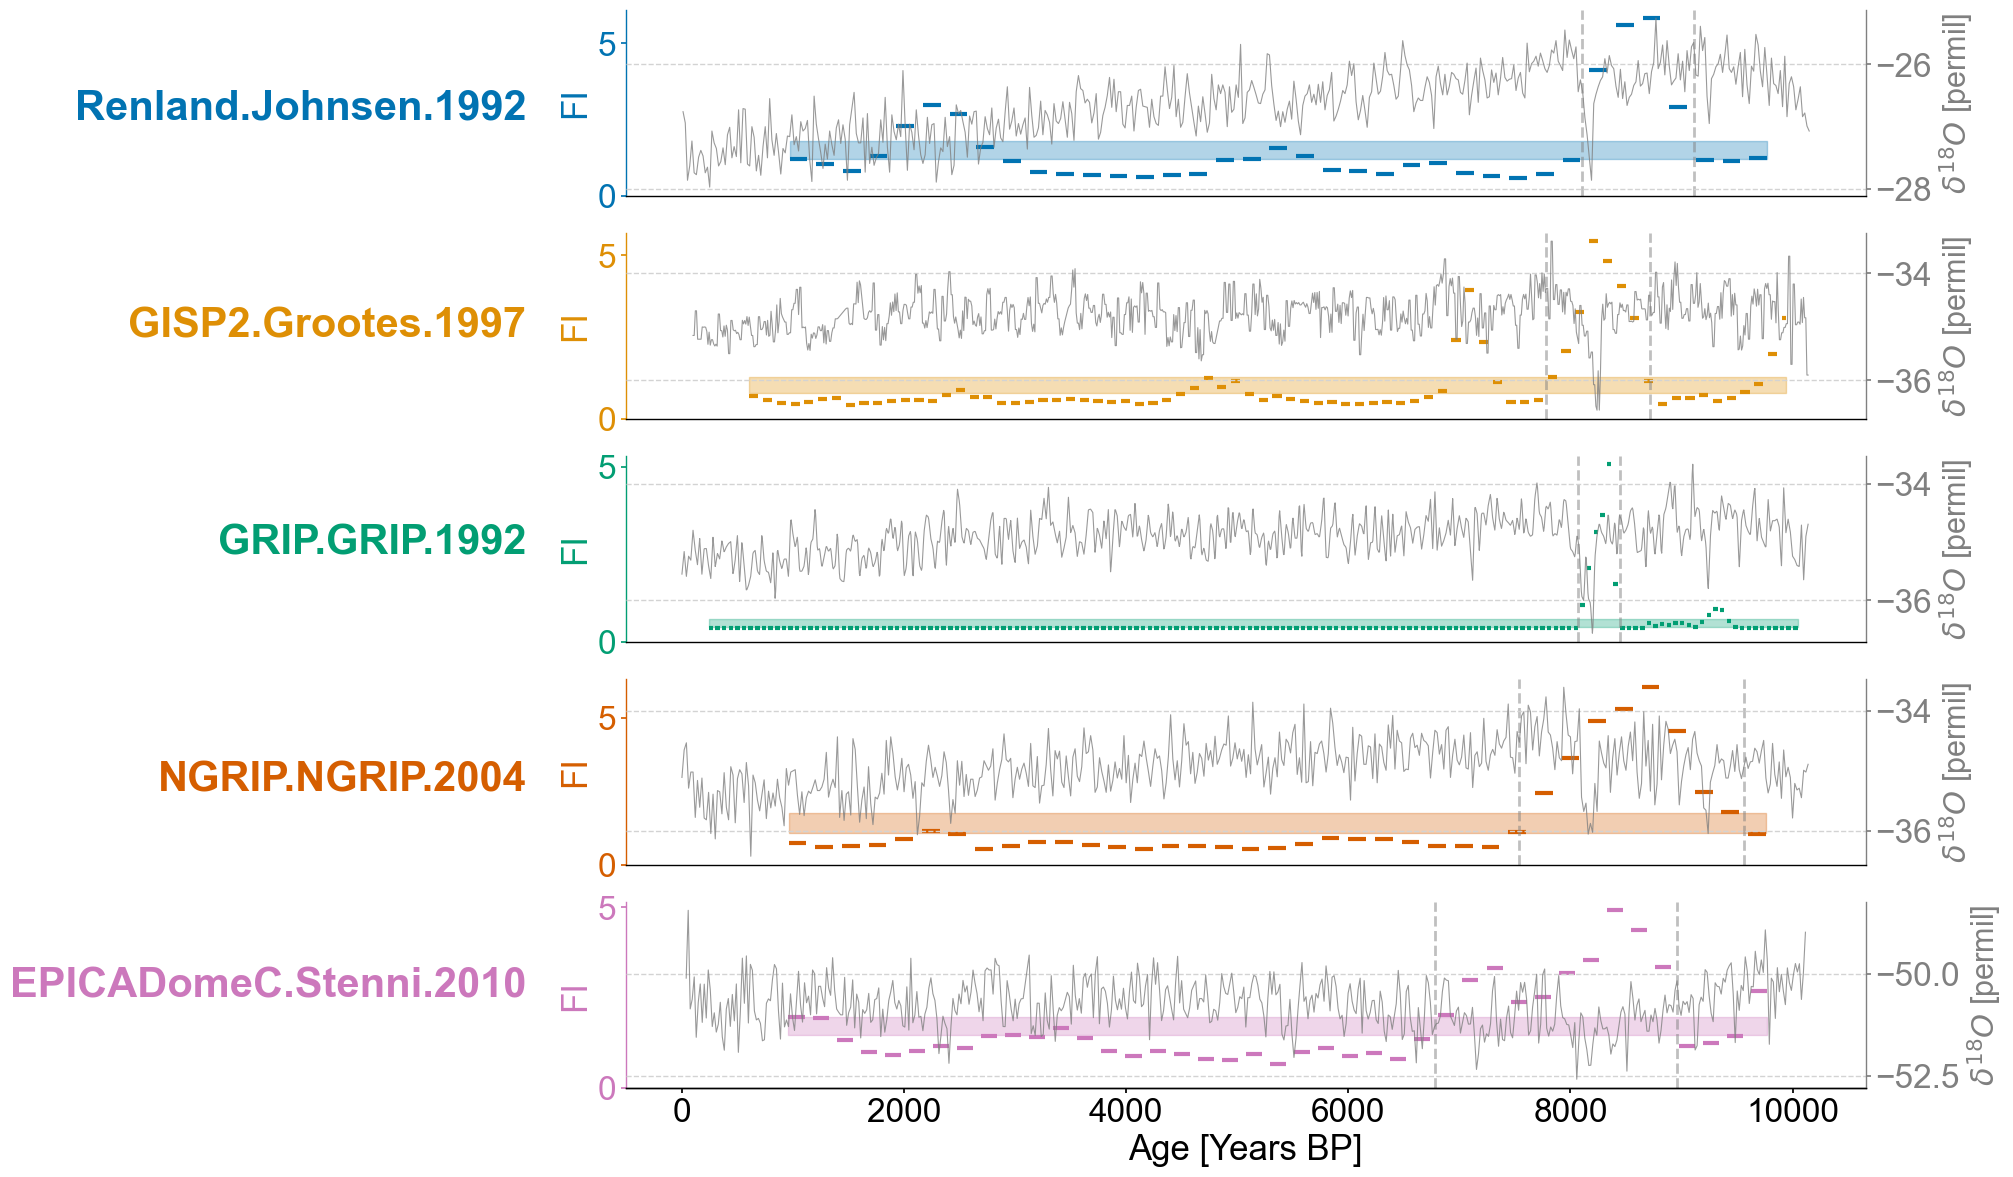

In [9]:
ms = greenland_ms

ordered_list = [
    'Renland.Johnsen.1992',
    'GISP2.Grootes.1997',
    'GRIP.GRIP.1992',
    'NGRIP.NGRIP.2004',
    'EPICADomeC.Stenni.2010'
]

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(ordered_list),ncols=1,sharex=True,figsize=(16,14))
transition_timing = []

for idx,record in enumerate(ordered_list):
    ts = lp_series_dict[record]
    ts.value_name = 'FI'
    ts.value_unit = None

    ax = axes[idx]
    ts_smooth = amt.utils.fisher.smooth_series(series=ts,block_size=3) #Using a block size of 3 for smoothing the Fisher information
    upper, lower = amt.utils.sampling.confidence_interval(series=ts,upper=95,lower=5,w=50,n_samples=10000) #Calculating the bounds for our confidence interval using default values 
    transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))
    transition_timing=[]
    
    for transition in transitions:
        if ts.label == "GISP2.Grootes.1997":
            if transition > 7500 and transition < 9000:
                transition_timing.append(transition)
        elif ts.label == "GRIP.GRIP.1992":
            if transition > 7500 and transition < 8700:
                transition_timing.append(transition)
        elif ts.label == "EPICADomeC.Stenni.2010":
            if transition > 6500 and transition < 9400:
                transition_timing.append(transition)
        elif ts.label == "NGRIP.NGRIP.2004":
            if transition > 6500:
                transition_timing.append(transition)
        else:
            if transition > 6200 and transition < 10000:
                transition_timing.append(transition)
    ts.confidence_smooth_plot(
        ax=ax,
        background_series = ms_dict[record].slice((0,end_time)),
        transition_interval=(upper,lower),
        block_size=3,
        color=color_list[idx],
        figsize=(12,6),
        legend=True,
        lgd_kwargs={'loc':'upper left'},
        hline_kwargs={'label':None},
        background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False,'linewidth':.8,'color':'grey','alpha':.8})
    
    for transition in transition_timing:
        ax.axvline(transition,color='grey',linestyle='dashed',alpha=.5)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(x=-.08, y = 2.5, s = ts.label, horizontalalignment='right', transform=trans, color=color_list[idx], weight='bold',fontsize=30)
        
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    ax.get_legend().remove()
    ax.set_title(None)
    ax.grid(visible=False,axis='y')
    if idx != len(lp_series_dict.keys())-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_yticks(ticks=np.array([0,5]))